In [1]:
from datasets import load_dataset, concatenate_datasets

cmu = load_dataset('CLAPv2/CMU_Arctic')
cmu = concatenate_datasets([*cmu.values()])
display(cmu)
print(f"\n{'-' * 50}\n")
display(cmu[0])

Resolving data files:   0%|          | 0/119 [00:00<?, ?it/s]

Dataset({
    features: ['index', 'datasetname', 'audio', 'audio_len', 'text', 'raw_text'],
    num_rows: 13192
})


--------------------------------------------------



{'index': './train/10005',
 'datasetname': 'FSD50K',
 'audio': <datasets.features._torchcodec.AudioDecoder at 0x7f79a4e84980>,
 'audio_len': 3.17006254196167,
 'text': 'A man reads out "He was fond of quoting a fragment from a certain poem." in the Scottish accent',
 'raw_text': ['Title: CMU_Arctic',
  'Description: The databases consist of around 1150 utterances carefully selected from out-of-copyright texts from Project Gutenberg. The databses include US English male (bdl) and female (slt) speakers (both experinced voice talent) as well as other accented speakers.',
  'License: BSD',
  'Text: He was fond of quoting a fragment from a certain poem.',
  'Accent: Scottish',
  'Gender: male',
  'Filename: cmu_sc_male/arctic_a0520.wav']}

In [2]:
import re
from torch.nn.utils.rnn import pad_sequence

def get_metadata(record):
    info     = '\n'.join(record['raw_text'])
    patterns = { 
        'speaker'    : r'Filename:\s*([^/]+)',
        'accent'     : r'Accent:\s*([^\n]+)', 
        'sex'        : r'Gender:\s*([^\n]+)',
        'spoken_text': r'Text:\s*([^\n]+)',
    }
    extract_pattern = lambda pattern: re.search(pattern, info).group(1).strip()
    metadata = { 'time_seconds': record['audio_len'] }
    metadata.update({ 
        key: extract_pattern(patterns[key]) for key in patterns
    })
    return metadata

def get_audio(record):
    audio = record['audio'].get_all_samples()
    samples = audio.data.mean(0)
    samplerate = audio.sample_rate
    return samples, samplerate

def get_audio_attrs(record):
    metadata            = get_metadata(record)
    dataset, samplerate = get_audio(record)
    return metadata, dataset, samplerate

metadata, dataset, samplerates = zip(*map(get_audio_attrs, cmu))

In [4]:
unique_samplerates = list(set(samplerates))
assert len(unique_samplerates) == 1, "When executing this check all the audios should've been already subsampled/supersampled to the same sampling rate."

In [5]:
samplerate  = unique_samplerates[0]
max_samples = max(map(len, dataset))

In [6]:
from collections import defaultdict
import re

key_components = ['accent', 'spoken_text']

audio_groups = defaultdict(list)
for idx, audio in enumerate(metadata):
    key = tuple(audio[x] for x in key_components)
    audio_groups[key].append(idx)

accents, spoken_texts = map(set, zip(*audio_groups.keys()))

print(f'''
Original Recordings:

Total Number of Recordings:      {len(cmu)}
Number of Accents:               {len(accents)}
Number of Spoken Texts:          {len(spoken_texts)}
Number of Accented Spoken Texts: {len(audio_groups)}
''')


Original Recordings:

Total Number of Recordings:      13192
Number of Accents:               5
Number of Spoken Texts:          1248
Number of Accented Spoken Texts: 5181



In [9]:
pairs = []
for key in audio_groups:
    audio_group = audio_groups[key]
    n = len(audio_group)
    if n < 2:
        continue
    for i in range(n-1):
        a = audio_group[i]
        for j in range(i+1, n):
            b = audio_group[j]
            t1, t2 = map(lambda idx: metadata[idx]['time_seconds'], [a, b])
            dt = 2 * abs(t1 - t2) / (t1 + t2)
            similar_tempos = dt < 0.01
            having_different_speakers = metadata[a]['speaker'] != metadata[b]['speaker']
            if similar_tempos and having_different_speakers:
                pairs.append([a, b])

print(f'''
Different-Speaker, Similar-Tempo, and Same-Accented-Text Recording Pairs:

Total Number of Pairs [Datapoints]: {len(pairs)}
''')


Different-Speaker, Similar-Tempo, and Same-Accented-Text Recording Pairs:

Total Number of Pairs [Datapoints]: 719



In [11]:
from IPython.display import Audio, display
from random import randint

def display_pair(dataset, samplerate, i, j):
    audios = map(lambda idx: Audio(dataset[idx], rate=samplerate), [i, j])
    for audio in audios:
        display(audio)

def choose_random_pair(pairs):
    return pairs[randint(0, len(pairs))]

def display_random_pair():
    global dataset, samplerate, pairs
    pair = choose_random_pair(pairs)
    print(f'\tPair: {pair}\n')
    display_pair(dataset, samplerate, *pair)
    return pair

i, j = display_random_pair()

	Pair: [1131, 9350]



In [75]:
import torch
import torch.nn.functional as F

pad = lambda samples, max_samples: F.pad(samples, pad=(0, max_samples - len(samples)), value=samples.abs().min())
X_t = torch.stack([pad(dataset[idx], max_samples) for idx in (i, j)])
original_samples = max(dataset[idx].numel() for idx in (i, j))
X_t.shape

torch.Size([2, 465120])

In [76]:
import torchaudio

FRAME_MS, HOP_MS = 15, 5

Spectrogram = torchaudio.transforms.Spectrogram(
    n_fft      = FRAME_MS * samplerate // 1000,
    win_length = FRAME_MS * samplerate // 1000,
    hop_length =   HOP_MS * samplerate // 1000,
    power      = None,
    window_fn  = torch.hann_window,
)

InvSpectrogram = torchaudio.transforms.InverseSpectrogram(
    n_fft      = FRAME_MS * samplerate // 1000,
    win_length = FRAME_MS * samplerate // 1000,
    hop_length =   HOP_MS * samplerate // 1000,
    window_fn  = torch.hann_window,
)

X_f = Spectrogram(samples)
A_f   = torch.abs(X_f)
phi_f = torch.angle(X_f)

A_f.shape, phi_f.shape

(torch.Size([2, 361, 1939]), torch.Size([2, 361, 1939]))

In [77]:
X_f = A_f * torch.exp(1j * phi_f)
X_f.shape

torch.Size([2, 361, 1939])

In [78]:
X_t = InvSpectrogram(X_f)
X_t.shape

torch.Size([2, 465120])

In [79]:
Audio(X_t[1], rate=samplerate)

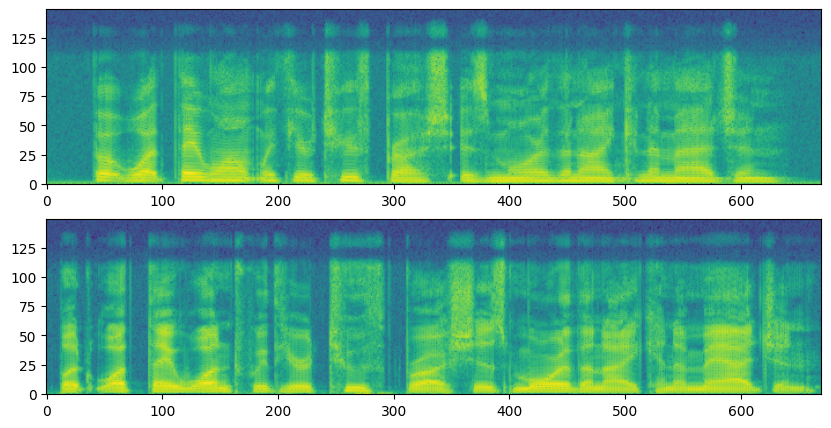

In [112]:
import matplotlib.pyplot as plt

images = A_f.detach().clone()
images[images == 0] = 1e-2
images = torch.log10(images)
images = images.numpy()[:, :150, :670]
_, axs = plt.subplots(2, 1, figsize=(10, 5))
axs[0].imshow(images[0], aspect='auto', origin='lower')
axs[1].imshow(images[1], aspect='auto', origin='lower')

In [91]:
FRAME_MS * samplerate // 1000

720

In [74]:
images[0]

array([[ 0.05206523,  0.01347971, -0.58038163, ...,        -inf,
               -inf,        -inf],
       [-0.26718035, -0.2142017 , -0.34645724, ...,        -inf,
               -inf,        -inf],
       [-1.720359  , -1.037054  , -0.76803523, ...,        -inf,
               -inf,        -inf],
       ...,
       [-6.243439  , -4.34269   , -4.018009  , ...,        -inf,
               -inf,        -inf],
       [-3.8075805 , -4.0384965 , -4.9791913 , ...,        -inf,
               -inf,        -inf],
       [-3.5872302 , -3.7571118 , -4.0581417 , ...,        -inf,
               -inf,        -inf]], shape=(361, 1939), dtype=float32)